In [34]:
%matplotlib inline
import numpy as np
import yt
from yt.fields.derived_field import ValidateSpatial
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [35]:
#
# Test out the chemical abundance stuff here 
#

NBINS = 15 + 1

binstart = -1.0
binend   = np.log10(14000.0)

bins     = np.logspace(binstart, binend, NBINS)[:-1]
db       = bins[1:] - bins[:-1]
db[0]    = bins[1] - 0.0
print(bins)


#sne_O = 1.17 * yt.units.Msun

#age_bin_zero = (db[0]) * yt.units.Myr # 0.1 to 1.0 Myr
#RSNe = 3.0E-4 / yt.units.Myr # SNe / Myr / solar mass 

#O_bin_zero  = age_bin_zero * RSNe * sne_O
#O_bin_one   = db[1] * yt.units.Myr * RSNe
#print(O_bin_zero, O_bin_one)

#O_bin_three = ((10.37 - db[3])*5.408E-4 + (db[4]-10.37)*2.516E-4) * sne_O
#print(O_bin_three)

[1.00000000e-01 2.20330795e-01 4.85456594e-01 1.06961038e+00
 2.35668105e+00 5.19249410e+00 1.14406636e+01 2.52073050e+01
 5.55394557e+01 1.22370524e+02 2.69619950e+02 5.94055780e+02
 1.30888783e+03 2.88388296e+03 6.35408227e+03]


In [95]:
elements = ['Total','He','C','N','O','Ne','Mg','Si','S','Ca','Fe']

element_num = {}
i = 0
for e in elements:
    element_num[e] = i
    i = i + 1

def sn_rate(t):
    # SN / Gyr  per solar msas of star formation
    #    Changed output to /Gyr to keep same units as input t
    
    agemin = 0.003401   # Gyr
    agebrk = 0.010370   # Gyr
    agemax = 0.03753    # Gyr
    
    RSNE = 0.0
    if (t>agemin):
        if (t <= agebrk):
            RSNE = 5.408E-4
        elif (t<=agemax):
            RSNE=2.516E-4
        
        if (t > agemax):
            RSNE=5.3E-8+1.6*np.exp(-0.5*((t-0.05)/0.01)*((t-0.05)/0.01)) # This is JUST SNIa
            RSNE=0.0 # set to zero
            
    return RSNE * 1000.0

def snIa_rate(t):
    agemin = 0.003401   # Gyr
    agebrk = 0.010370   # Gyr
    agemax = 0.03753    # Gyr
    
    RSNE = 0.0
    if (t > agemax):
        RSNE=5.3E-8+1.6E-5*np.exp(-0.5*((t-0.05)/0.01)*((t-0.05)/0.01)) # This is JUST SNIa
            
    return RSNE * 1000.0

#def wind_rate(t):

def wind_yields(i,element=None):
    yields = [0.0, 0.36,0.016,0.0041,0.0118] + [0.0]*6
    yields[0] = np.sum(yields[1:])
    # if element passed, use that - otherwise use yield indeces
    if not (element is None):
        if element == 'all':
            return yields

    return yields[i]    

def snIa_yields(i, element = None):
    yields = [1.4,0.0,0.049,1.2E-6,0.143,0.0045,0.0086,0.156,0.087,0.012,0.743]
    
    # if element passed, use that - otherwise use yield indeces
    if not (element is None):
        if element == 'all':
            return yields

    return yields[i]
    
def snII_yields(i, element = None):
    # if element passed, use that - otherwise use yield indeces
    
    yields = [2.0,3.87,0.133,0.0479,1.17,0.30,0.0987,0.0933,0.0397,0.00458,0.0741]

    if not (element is None):
        if element == 'all':
            return yields
        
        i = element_num[element]
    

    return yields[i]    

def construct_yields(agebins, yieldtype = 'total'):

    points = [0.003401, 0.010370, 0.03753]
    
    yields = np.zeros( (np.size(agebins), np.size(elements))) 
    
    print( np.shape(yields))
    
    if yieldtype == 'snII' or yieldtype == 'total':
        numsnII = np.zeros(np.size(agebins))
        
        for i in np.arange(np.size(agebins) - 1):
            
            if i == 0:
                mint = 0.0
            else:
                mint = agebins[i]
            maxt = agebins[i+1]
            numsnII[i] = integrate.quad( sn_rate, mint, maxt, points = points)[0]
            
        numsnII[-1] = integrate.quad(sn_rate, agebins[-1], 14.0, points = points)[0]  
        
        print(numsnII)
        
        yields += np.outer(numsnII, snII_yields(-1, element = 'all'))
    
    if yieldtype == 'snIa' or yieldtype == 'total':    
        numsnIa = np.zeros(np.size(agebins))
        
        for i in np.arange(np.size(agebins) - 1 ):
            
            if i == 0:
                mint = 0.0
            else:
                mint = agebins[i]
            maxt = agebins[i+1]
            numsnIa[i] = integrate.quad( snIa_rate, mint, maxt, points = points)[0]
        numsnIa[-1] = integrate.quad(snIa_rate, agebins[-1], 14.2, points = points)[0]
        
        yields += np.outer(numsnIa, snIa_yields(-1, element = 'all'))        
        
        
    return yields


In [96]:
total_yield_masses = construct_yields(bins/1000.0, yieldtype = 'total')
print(bins)
print(total_yield_masses[:,4])

(15, 11)
[0.         0.         0.         0.         0.00096884 0.00306937
 0.00346369 0.00310039 0.         0.         0.         0.
 0.         0.         0.        ]
[1.00000000e-01 2.20330795e-01 4.85456594e-01 1.06961038e+00
 2.35668105e+00 5.19249410e+00 1.14406636e+01 2.52073050e+01
 5.55394557e+01 1.22370524e+02 2.69619950e+02 5.94055780e+02
 1.30888783e+03 2.88388296e+03 6.35408227e+03]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.13354281e-03 3.59116775e-03 4.05251378e-03 3.66223287e-03
 1.71274839e-05 1.11600340e-06 2.45889916e-06 5.41771208e-06
 1.19368881e-05 2.63006405e-05 5.94642105e-05]


[0.       0.294372 0.632736]
0.019236588228


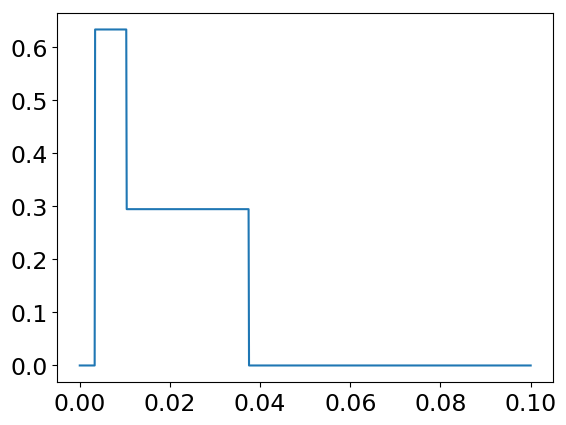

In [97]:
t = np.linspace(0.0, 0.1, 1000)
y = np.array([sn_rate(x) for x in t]) * 1.17

print(np.unique(y))

print(0.294372 * (0.010370 - 0.003401) + 0.632736 * (0.03753 - 0.010370))

plt.plot(t,y)

In [113]:

def generate_metal_fields(ds, _agebins=bins, 
                              _elements=elements,
                              _yields=total_yield_masses,
                              ptype='PartType0'):
    
    offset = 15 
    #ptype = 'PartType0'
    
    def _metal_mass_test(_ptype, _ei):
        # test metals in bin zero 
    
        def temp(field,data):
            mass_p = np.zeros(np.shape( data[(_ptype,'particle_mass')]))
            for i in np.arange(np.size(_agebins)):
                fname    = 'Metallicity_%02i'%(offset + i)
                mass_p += data[(ptype,fname)].value * _yields[i,_ei] #(agebinnum,  elementnum)
            
            mass_p = mass_p * yt.units.Msun
          
            return mass_p
        
        return temp
    
    def _metal_fraction_test(_ptype, _e):
        def temp(field,data):
            Mp    = data[(_ptype,'particle_mass')].to('Msun')
            abund = data[('all',_ptype + '_' + _e + '_mass')].to('Msun') / Mp
            abund[Mp==0.0] = 0.0
            return abund
        return temp
    
    def _metal_mass_actual_test(_ptype,_ei):
        def temp(field,data):
            Mp    = data[(_ptype,'particle_mass')].to('Msun')
            abund = data[(_ptype,"Metallicity_%02i"%(_ei))]
        
            
            return abund*Mp
        return temp
            
    
    
    for ei,e in enumerate(_elements):

        ds.add_field( ('all', ptype + '_' + e + '_mass'), sampling_type='particle', 
                      function=_metal_mass_test(ptype, ei),
                      units = 'Msun', force_override=True)
        ds.add_field(  ('all',ptype + '_' + e + '_fraction'), sampling_type='particle',
                      function=_metal_fraction_test(ptype,e),
                      units='', force_override=True)
        
        ds.add_field( ('all',ptype + '_' + e + '_actual_mass'), sampling_type='particle',
                       function=_metal_mass_actual_test(ptype,ei),
                       units='Msun', force_override=True)
        
    return    

def _generate_star_metal_fields(ds,
                                _agebins=bins, 
                                _elements=elements,
                                _yields=total_yield_masses,
                                ptype='PartType4'):
    
    offset = 15
    
    def _star_metal_mass_test(_ptype, _ei):
        # test metals in bin zero 
    
        def temp(field,data):
            mass_p = np.zeros(np.shape( data[(_ptype,'particle_mass')]))
            for i in np.arange(np.size(_agebins)):
                fname    = 'Metallicity_%02i'%(offset + i)
                mass_p += data[(ptype,fname)].value * _yields[i,_ei] #(agebinnum,  elementnum)
            
            mass_p = mass_p * yt.units.Msun
          
            return mass_p
        
        return temp
    
        
    for ei,e in enumerate(_elements):

        ds.add_field( ('all', ptype + '_' + e + '_mass'), sampling_type='particle', 
                      function=_star_metal_mass_test(ptype, ei),
                      units = 'Msun', force_override=True)
        
    return

In [99]:
print(bins)

[1.00000000e-01 2.20330795e-01 4.85456594e-01 1.06961038e+00
 2.35668105e+00 5.19249410e+00 1.14406636e+01 2.52073050e+01
 5.55394557e+01 1.22370524e+02 2.69619950e+02 5.94055780e+02
 1.30888783e+03 2.88388296e+03 6.35408227e+03]


In [100]:
ds0    = yt.load('./agetracers/snapshot_000.hdf5')
data0   = ds0.all_data()
generate_metal_fields(ds0)

mtrue_initial = {}
for e in elements:
    m = data0[('all','PartType0_'+e+'_actual_mass')]
    mtrue_initial[e] = np.sum( m ).to('Msun')
    
print(mtrue_initial)

yt : [INFO     ] 2019-08-26 18:05:52,504 Calculating time from 0.000e+00 to be 3.063e+17 seconds
yt : [INFO     ] 2019-08-26 18:05:52,505 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2019-08-26 18:05:52,526 Parameters: current_time              = 3.063114274545048e+17 s
yt : [INFO     ] 2019-08-26 18:05:52,528 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-08-26 18:05:52,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-08-26 18:05:52,530 Parameters: domain_right_edge         = [10000. 10000. 10000.]
yt : [INFO     ] 2019-08-26 18:05:52,531 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-08-26 18:05:52,532 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2019-08-26 18:05:52,533 Parameters: omega_lambda              = 0.73
yt : [INFO     ] 2019-08-26 18:05:52,533 Parameters: omega_matter              = 0.27
yt : [INFO     ] 2019-08-26 18:05:52,533 Parameters: omega_radiation           = 0.0
y

{'Total': 0.17999999837155184 Msun, 'He': 2249999988.6349545 Msun, 'C': 0.02933999903199995 Msun, 'N': 0.011879999853491148 Msun, 'O': 0.07784999949085256 Msun, 'Ne': 0.019979999975367365 Msun, 'Mg': 0.00837899960023613 Msun, 'Si': 0.009720000146251467 Msun, 'S': 0.005795999881210795 Msun, 'Ca': 0.0009089999825064082 Msun, 'Fe': 0.015570000288483297 Msun}


In [101]:
ds0.field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metallicity_01'),
 ('PartType0', 'Metallicity_02'),
 ('PartType0', 'Metallicity_03'),
 ('PartType0', 'Metallicity_04'),
 ('PartType0', 'Metallicity_05'),
 ('PartType0', 'Metallicity_06'),
 ('PartType0', 'Metallicity_07'),
 ('PartType0', 'Metallicity_08'),
 ('PartType0', 'Metallicity_09'),
 ('PartType0', 'Metallicity_10'),
 ('PartType0', 'Metallicity_11'),
 ('PartType0', 'Metallicity_12'),
 ('PartType0', 'Metallicity_13'),
 ('PartType0', 'Metallicity_14'),
 ('PartType0', 'Metallicity_15'),
 ('PartType0', 'Metallicity_16'),
 ('PartType0', 'Metallicity_17'),
 ('PartType0', 'Metallicity_18'),
 ('PartType0', 'Metallicity_19'),
 ('PartType0', 'Metallicity_20'),
 ('PartType0', 'Metallicity_21'),
 ('PartType0', 'Metallicity_22'),
 ('PartType0', 'Metallicity_23'),
 ('PartType0', 'Metallicity_2

In [121]:
ds = yt.load('./agetracers/old_working/snapshot_016.hdf5')
data = ds.all_data()
fields = ds.field_list
generate_metal_fields(ds)

ptypes = np.unique([x[0] for x in ds.field_list])
metals = np.unique([x[1] for x in ds.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

print("Number of particle types      ",ptypes)
print("Number of tracer metals       ",np.size(metals))

M_new_stars = 0.0 * yt.units.Msun
if 'PartType4' in ptypes:
    print("Number of new stars    ", np.size(data[('PartType4','Metallicity_00')]))
    M_new_stars = data[('PartType4','particle_mass')].to('Msun')
    
    _generate_star_metal_fields(ds)
    
if np.size(metals) > 11 + 4:
    for i in np.arange(0, np.size(metals)):
        z = data[('PartType0','Metallicity_%02i'%(i))]
        print("Metallicity_"+str(i)+"     ", np.min(z.value), np.max(z.value))

#print(np.max(data['density'].to('g/cm**3')) / yt.physical_constants.mass_hydrogen_cgs  / 0.6)
#print(ds.current_time, ds.current_time.to('Myr'))

yt : [INFO     ] 2019-08-26 18:24:53,684 Calculating time from 1.600e-02 to be 3.063e+17 seconds
yt : [INFO     ] 2019-08-26 18:24:53,685 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2019-08-26 18:24:53,708 Parameters: current_time              = 3.063114274545048e+17 s
yt : [INFO     ] 2019-08-26 18:24:53,709 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2019-08-26 18:24:53,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-08-26 18:24:53,711 Parameters: domain_right_edge         = [10000. 10000. 10000.]
yt : [INFO     ] 2019-08-26 18:24:53,712 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-08-26 18:24:53,713 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2019-08-26 18:24:53,713 Parameters: omega_lambda              = 0.73
yt : [INFO     ] 2019-08-26 18:24:53,714 Parameters: omega_matter              = 0.27
yt : [INFO     ] 2019-08-26 18:24:53,715 Parameters: omega_radiation           = 0.0
y

Number of particle types       ['PartType0' 'PartType1' 'PartType2' 'PartType3' 'PartType4' 'PartType5'
 'all']
Number of tracer metals        30
Number of new stars     220
Metallicity_0      1.9871106496371915e-11 0.002693378832191229
Metallicity_1      0.24420754611492157 0.25017309188842773
Metallicity_2      3.2389872034466194e-12 0.00018350461323279887
Metallicity_3      1.3080336510110091e-12 3.167829021322177e-08
Metallicity_4      8.594258985028524e-12 0.0016142887761816382
Metallicity_5      2.205694177651041e-12 0.00041392017737962306
Metallicity_6      9.25000093882078e-13 0.0001361797476420179
Metallicity_7      1.0730395521782454e-12 0.0001287291815970093
Metallicity_8      6.398492304569847e-13 5.477543891174719e-05
Metallicity_9      1.0034899614822651e-13 6.319181466096779e-06
Metallicity_10      1.7188491298683606e-12 0.00010223828576272354
Metallicity_11      0.0 0.0
Metallicity_12      0.0 6.35051691233457e-08
Metallicity_13      0.0 0.0
Metallicity_14      0.0 2.93

In [122]:
for i in np.arange(15,29):
    newstar = data[('PartType4','Metallicity_%2i'%(i))]
    gas = data[('PartType0','Metallicity_%2i'%(i))]
    print(str(i) + "    %5.5f"%(np.sum(newstar)/ np.sum(gas)))

15    0.04598
16    0.04310
17    0.03969
18    0.03198
19    0.02645
20    0.01012
21    0.00517
22    0.00263


/home/aemerick/.local/lib/python3.7/site-packages/yt/units/yt_array.py:1395: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


23      nan
24      nan
25      nan
26      nan
27      nan
28      nan


In [123]:
t0 = data[('PartType4','StellarFormationTime')] * 1000.0
print(np.min(t0),np.max(t0))
for i,x in enumerate(bins):
    print("%i    %5.5f"%(i, x))

0.9765625 dimensionless 15.89202880859375 dimensionless
0    0.10000
1    0.22033
2    0.48546
3    1.06961
4    2.35668
5    5.19249
6    11.44066
7    25.20731
8    55.53946
9    122.37052
10    269.61995
11    594.05578
12    1308.88783
13    2883.88296
14    6354.08227


In [124]:
max_oxygen = np.sum(M_new_stars)* (0.294372 * (0.010370 - 0.003401) + 0.632736 * (0.03753 - 0.010370))
print("%5.5E"%(max_oxygen))

1.04271E+06


In [125]:
#O        = data[('all','PartType0_Fe_mass')]
#O_actual = data[('all','PartType0_Fe_actual_mass')]

#print(np.sum(O)/1.0E5, np.size(O))
#print(np.sum(O_actual)/1.0E5, np.size(O_actual))

#m  = data[('PartType0','particle_mass')].to('Msun')
#print(np.sum(m), np.sum(O_actual) / np.sum(m))

print(elements)
tolerance = 1.0E-4 * yt.units.Msun

O       = np.sum(data[('all','PartType0_O_mass')])
Oactual = np.sum(data[('all','PartType0_O_actual_mass')])
Oyield = 1.17
snIIyield=np.array(snII_yields(-1,element='all'))


for ei,e in enumerate(elements):
    if e=='Total':
        continue
        
    m = data[('all','PartType0_' + e + '_mass')]
    
    mstar = 0.0 * yt.units.Msun
    if 'PartType4' in ptypes:
        mstar = data[('all','PartType4_' + e + '_mass')]
        
    
    mtrue = data[('all','PartType0_'+e+'_actual_mass')]
    
    
    mtrue_total = np.max( [(np.sum(mtrue) - mtrue_initial[e]) - tolerance, 0.0])
    m_total     = np.sum(m) + np.sum(mstar)
    
    if mtrue_total == 0.0:
        error = 0.00
    else:
        error       = (m_total.value - mtrue_total) / mtrue_total
    
    
    print("%2s   %5.5E    %5.5E    %5.5E   %5.5E    %5.5E    %5.5E"%(e, m_total, mtrue_total, error,
                                                         m_total/O, snIIyield[ei]/snIIyield[4], mtrue_total / Oactual))

['Total', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca', 'Fe']
He   9.91259E+05    0.00000E+00    0.00000E+00   3.34417E+00    3.30769E+00    0.00000E+00
 C   3.41010E+04    1.07190E+04    2.18134E+00   1.15045E-01    1.13675E-01    1.13675E-01
 N   1.22691E+04    2.50653E-01    4.89475E+04   4.13917E-02    4.09402E-02    2.65817E-06
 O   2.99784E+05    9.42953E+04    2.17920E+00   1.01137E+00    1.00000E+00    9.99999E-01
Ne   7.68450E+04    2.41783E+04    2.17826E+00   2.59249E-01    2.56410E-01    2.56410E-01
Mg   2.52870E+04    7.95465E+03    2.17889E+00   8.53097E-02    8.43590E-02    8.43589E-02
Si   2.40074E+04    7.51945E+03    2.19271E+00   8.09927E-02    7.97436E-02    7.97435E-02
 S   1.02298E+04    3.19959E+03    2.19723E+00   3.45120E-02    3.39316E-02    3.39316E-02
Ca   1.18155E+03    3.69122E+02    2.20097E+00   3.98613E-03    3.91453E-03    3.91453E-03
Fe   1.95018E+04    5.97204E+03    2.26552E+00   6.57924E-02    6.33333E-02    6.33333E-02


In [14]:
ds.field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity_00'),
 ('PartType0', 'Metallicity_01'),
 ('PartType0', 'Metallicity_02'),
 ('PartType0', 'Metallicity_03'),
 ('PartType0', 'Metallicity_04'),
 ('PartType0', 'Metallicity_05'),
 ('PartType0', 'Metallicity_06'),
 ('PartType0', 'Metallicity_07'),
 ('PartType0', 'Metallicity_08'),
 ('PartType0', 'Metallicity_09'),
 ('PartType0', 'Metallicity_10'),
 ('PartType0', 'Metallicity_11'),
 ('PartType0', 'Metallicity_12'),
 ('PartType0', 'Metallicity_13'),
 ('PartType0', 'Metallicity_14'),
 ('PartType0', 'Metallicity_15'),
 ('PartType0', 'Metallicity_16'),
 ('PartType0', 'Metallicity_17'),
 ('PartType0', 'Metallicity_18'),
 ('PartType0', 'Metallicity_19'),
 ('PartType0', 'Metallicity_20'),
 ('PartType0', 'Metallicity_21'),
 ('PartType0', 'Metallicity_22'),
 ('PartType0', 'Metallicity_23'),
 ('PartType0', 'Metallicity_2

In [15]:
pp = yt.ParticlePlot(ds,('PartType0','particle_position_x'),
                        ('PartType0','particle_position_y'), 
                        ('Ps')) #, width = (50,'kpc'))
#pp.set_unit('Density','g/cm**3')
pp.show()

YTFieldNotFound: Could not find field '('all', 'Ps')' in snapshot_050.

In [ ]:
def _deposit_test(field,data):
    
    ptype  = 'PartType0'
    fname  = "Metallicity_15"
    method = 'cic'
    units  = '' 
    
    pos  = data[(ptype,"particle_position")]
    pden = data[(ptype,"particle_mass")]
    
    top  = data.deposit(pos, [data[(ptype,fname)]*pden], method=method)
    bottom = data.deposit(pos, [pden], method=method)
    top[bottom==0]=0.0
    bnz = bottom.nonzero()
    top[bnz] /= bottom[bnz]
    d = data.ds.arr(top, input_units=units)
    return d

ds.add_field( ('deposit',"PartType0_Metallicity_15"), sampling_type='cell',
               function = _deposit_test, units = '', take_log = True,
               validators=[ValidateSpatial(0)],force_override=True)

In [ ]:
def _metal_test(field,data):
    # test metals in bin zero 
    
    ptype = 'PartType0'
    fname = 'Metallicity_16' # age bin zero 
    
    M_binzero = O_bin_one # solar masses of Oxygen produced in first time bin per Msun of SF
    
    M_p     = data[(ptype,fname)].value * M_binzero
    
    abund_p = M_p.value  #/ data[(ptype,"particle_mass")].to('Msun')
    abund_p[M_p==0.0] = 0.0
    
    return abund_p

ds.add_field( ('all','testbinzero'), sampling_type='particle', 
              function=_metal_test, units = '', force_override=True)


x = data[('all','testbinzero')]  / data[('PartType0','particle_mass')].to('Msun').value
print(np.min(x), np.max(x), np.average(x))
print(np.min(data['all','testbinzero']), np.max(data['all','testbinzero']))
print(np.min(data['PartType0','particle_mass'].to('Msun')), np.max(data['PartType0','particle_mass'].to('Msun')))

In [ ]:

pp = yt.ProjectionPlot(ds,'x',('deposit','PartType0_Metallicity_15'), width = (50,'kpc'))
pp.show()

In [ ]:
pp = yt.ParticlePlot(ds,('PartType2','particle_position_x'),
                        ('PartType2','particle_position_y'), 
                        ('PartType2','Metallicity_17'), width = (50,'kpc'))
#pp.set_unit('Density','g/cm**3')
pp.show()

In [ ]:
pp = yt.ParticlePlot(ds,('PartType0','particle_position_x'),
                        ('PartType0','particle_position_y'), 
                        ('PartType0','Temperature'), width = (50,'kpc'))
#pp.set_unit('Density','g/cm**3')
pp.show()

In [ ]:
sm     = data[('PartType4','Masses')].to('Msun')
tform  = (data[('PartType4', 'StellarFormationTime')].value * ds.time_unit).to('Myr')
tnow   = 0.02 * ds.time_unit.to('Myr')
ages   = tnow - tform
print(np.size(sm), np.sum(sm) / 1.0E7)

print( np.min(tform),np.max(tform),np.min(ages),np.max(ages))